# Data Analysis for Neural Networks Paper
## Preparation
### Import Dependencies

In [2]:
import os
import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
import seaborn as sns
#from RL_utils import *
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.patches as mpatches
from itertools import combinations
from scipy.spatial import distance
from scipy.ndimage.filters import gaussian_filter1d

### Load Data

In [3]:
folder_name = '3999_16.100'
path = './Results/TowerTraining/'+folder_name+'/'
figure_path = './Results/TowerTraining/NNFigures/'

obs = np.load(path+'visobs.npy', mmap_mode='r')
vec = np.load(path+'vecobs.npy')

rew = np.load(path+'rewards.npy')

encA = np.load(path+'encodings.npy')
encA = encA.reshape(encA.shape[0],encA.shape[-1])[:,:256]
#encR = np.load(path+'randenc.npy')[:,:256]#for random activations
encAE = np.load(path+'AEAct.npy')
encAE = encAE.reshape(encAE.shape[0],encAE.shape[-1])[:,:256]
encC = np.load(path+'ClassAct.npy')

actionL = np.load(path+'actions.npy')
val = np.load(path+'values.npy')
outAE = np.load(path+'AEOut.npy')
outClass = np.load(path+'ClassOut.npy')

doors = np.load(path+'doors.npy')
Rewards = np.load(path+'reward_per.npy')

hand_l = pd.read_csv(path+'HandLabels.csv')
label_test = np.zeros(encA.shape[0])
label_test = np.array(hand_l['Label'])

### General Functions Needed

In [4]:
def getClusterVariance(cluster,data,num_cluster):
    between_var = np.var(data,axis=0)
    within_var = []
    for i in range(num_cluster):
        which = np.where(cluster==i)
        within_var.append(np.var(data[which],axis=0))
    b = np.mean(between_var)
    w = np.zeros(num_cluster)
    for i in range(num_cluster):
        w[i] = np.mean(within_var[i])
    return between_var, within_var, b, w
def getDistances(points):
    distances = [distance.euclidean(p1, p2) for p1, p2 in combinations(points, 2)]
    return distances
def getAcrossD(c1,c2):
    comb = [(x,y) for x in c1 for y in c2]
    distances = [distance.euclidean(p1, p2) for p1, p2 in comb]
    return distances
def getCorDistances(points):
    distances = [distance.correlation(p1, p2) for p1, p2 in combinations(points, 2)]
    return distances
def getAcrossCorD(c1,c2):
    comb = [(x,y) for x in c1 for y in c2]
    distances = [distance.correlation(p1, p2) for p1, p2 in comb]
    return distances
def where_array_equal(a,b):
    equal = np.zeros(a.shape[0])
    for i,arr in enumerate(a):
        if np.array_equal(arr,b):
            equal[i] = 1
    return equal

### Some Precalculations

In [5]:
w = where_array_equal(actionL[:,0],np.unique(actionL[:,0],axis=0)[3])

combs = np.unique(actionL[:,0],axis=0)
a_vec = np.zeros((combs.shape[0],actionL.shape[0]))
for i,c in enumerate(combs):
    a_vec[i] = where_array_equal(actionL[:,0],c)
#print(a_vec.shape)    

all_a_comb = np.zeros(actionL.shape[0])
for i in range(actionL.shape[0]):
    if a_vec[0][i] == 1:
        all_a_comb[i] = 0#[1, 0, 0, 1] Forward, Turn right
    elif a_vec[3][i] == 1:
        all_a_comb[i] = 1#[1, 1, 0, 1] Forward, Camera Left, Turn Right
    elif a_vec[4][i] == 1:
        all_a_comb[i] = 2#[1, 1, 0, 2] Forward, Camera Left, Turn Left
    elif a_vec[6][i] == 1:
        all_a_comb[i] = 3#[1, 2, 0, 1] Forward, Camera Right, Turn Right
    elif a_vec[13][i] == 1:
        all_a_comb[i] = 4#[2, 2, 0, 1] Backward, Camera Right, Turn Right
    else:
        all_a_comb[i] = 5#Anything else
actions = ['Forward, Turn Right','Forward, Camera Left, Turn Right','Forward, Camera Left, Turn Left',
           'Forward, Camera Right, Turn Right','Backward, Camera Right, Turn Right','Everything Else']

## Analysis of Activation Patterns
### Sparseness of Activations

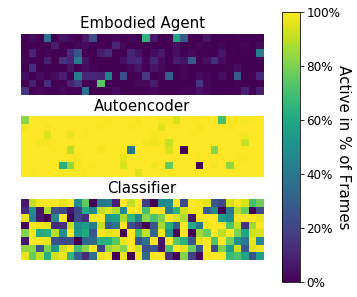

In [6]:
perActA = np.sum((encA)>0,axis=0)/encA.shape[0]
perActAE = np.sum((encAE)>0,axis=0)/encAE.shape[0]
perActC = np.sum((encC)>0,axis=0)/encC.shape[0]
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(3, 1, 1)
im2 = plt.imshow(perActA.reshape(8,32), vmin=0, vmax=1)
plt.title('Embodied Agent',fontsize=15)
plt.axis('off')
ax2 = fig.add_subplot(3, 1, 2)
im1 = plt.imshow(perActAE.reshape(8,32), vmin=0, vmax=1)
plt.title('Autoencoder',fontsize=15)
plt.axis('off')
ax3 = fig.add_subplot(3, 1, 3)
im3 = plt.imshow(perActC.reshape(8,32), vmin=0, vmax=1)
plt.title('Classifier',fontsize=15)
plt.axis('off')
#plt.suptitle('Visual Encoding',fontsize=18)
fig.subplots_adjust(right=0.8,top=0.85,bottom=0.2)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.75])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.ax.set_yticklabels(['0%', '20%', '40%','60%','80%','100%'],fontsize=12)
cbar.set_label('Active in % of Frames', rotation=270,fontsize=15, labelpad=10)

#plt.show()
plt.savefig(figure_path+'PerAct.eps', bbox_inches='tight', dpi=300)

In [6]:
print("Embodied Agent:")
print("Average number of neurons active per frame (visual): "+str(np.mean(np.sum(encA[:,:256]>0,axis=1)))+" (min="+str(np.min(np.sum(encA[:,:256]>0,axis=1)))+
      " max="+str(np.max(np.sum(encA[:,:256]>0,axis=1)))+" var="+str(np.round(np.var(np.sum(encA[:,:256]>0,axis=1)),3))+")")
print("This is "+str(np.round(np.mean(np.sum(encA[:,:256]>0,axis=1))/256*100,3))+"% of all neurons.")
visActPer = np.sum((encA[:,:256])>0,axis=0)/encA.shape[0]*100
print("In the visual encoding "+str(np.sum(visActPer>0))+" of the 256 neurons are active in at least 1 frame (="+
     str(np.round(np.sum(visActPer>0)/256*100,3))+"%), "+str(np.sum(visActPer>40))+" neurons are active in more than 40% of the frames (="+
     str(np.round(np.sum(visActPer>40)/256*100,3))+"%). "+str(np.sum(visActPer==0))+" neurons are never active (="+str(np.round(np.sum(visActPer==0)/256*100,3))+
     "%). The most active neuron is active in "+str(np.max(visActPer))+"% of the frames.")
vecActPer = np.sum((encA[:,256:])>0,axis=0)/encA.shape[0]*100

print("\nAutoencoder:")
print("Average number of neurons active per frame (visual): "+str(np.mean(np.sum(encAE[:,:256]>0,axis=1)))+" (min="+str(np.min(np.sum(encAE[:,:256]>0,axis=1)))+
      " max="+str(np.max(np.sum(encAE[:,:256]>0,axis=1)))+" var="+str(np.round(np.var(np.sum(encAE[:,:256]>0,axis=1)),3))+")")
print("This is "+str(np.round(np.mean(np.sum(encAE[:,:256]>0,axis=1))/256*100,3))+"% of all neurons.")
visActPer = np.sum((encAE[:,:256])>0,axis=0)/encAE.shape[0]*100
print("In the visual encoding "+str(np.sum(visActPer>0))+" of the 256 neurons are active in at least 1 frame (="+
     str(np.round(np.sum(visActPer>0)/256*100,3))+"%), "+str(np.sum(visActPer>40))+" neurons are active in more than 40% of the frames (="+
     str(np.round(np.sum(visActPer>40)/256*100,3))+"%). "+str(np.sum(visActPer==0))+" neurons are never active (="+str(np.round(np.sum(visActPer==0)/256*100,3))+
     "%). The most active neuron is active in "+str(np.max(visActPer))+"% of the frames.")
vecActPer = np.sum((encAE[:,256:])>0,axis=0)/encAE.shape[0]*100

print("\nClassifier:")
print("Average number of neurons active per frame (visual): "+str(np.mean(np.sum(encC[:,:256]>0,axis=1)))+" (min="+str(np.min(np.sum(encC[:,:256]>0,axis=1)))+
      " max="+str(np.max(np.sum(encC[:,:256]>0,axis=1)))+" var="+str(np.round(np.var(np.sum(encC[:,:256]>0,axis=1)),3))+")")
print("This is "+str(np.round(np.mean(np.sum(encC[:,:256]>0,axis=1))/256*100,3))+"% of all neurons.")
visActPer = np.sum((encC[:,:256])>0,axis=0)/encC.shape[0]*100
print("In the visual encoding "+str(np.sum(visActPer>0))+" of the 256 neurons are active in at least 1 frame (="+
     str(np.round(np.sum(visActPer>0)/256*100,3))+"%), "+str(np.sum(visActPer>40))+" neurons are active in more than 40% of the frames (="+
     str(np.round(np.sum(visActPer>40)/256*100,3))+"%). "+str(np.sum(visActPer==0))+" neurons are never active (="+str(np.round(np.sum(visActPer==0)/256*100,3))+
     "%). The most active neuron is active in "+str(np.max(visActPer))+"% of the frames.")
vecActPer = np.sum((encC[:,256:])>0,axis=0)/encC.shape[0]*100

Embodied Agent:
Average number of neurons active per frame (visual): 11.8805 (min=3 max=35 var=17.891)
This is 4.641% of all neurons.
In the visual encoding 173 of the 256 neurons are active in at least 1 frame (=67.578%), 7 neurons are active in more than 40% of the frames (=2.734%). 83 neurons are never active (=32.422%). The most active neuron is active in 74.15% of the frames.

Autoencoder:
Average number of neurons active per frame (visual): 250.47575 (min=227 max=254 var=15.994)
This is 97.842% of all neurons.
In the visual encoding 254 of the 256 neurons are active in at least 1 frame (=99.219%), 254 neurons are active in more than 40% of the frames (=99.219%). 2 neurons are never active (=0.781%). The most active neuron is active in 100.0% of the frames.

Classifier:
Average number of neurons active per frame (visual): 165.02975 (min=139 max=188 var=51.87)
This is 64.465% of all neurons.
In the visual encoding 245 of the 256 neurons are active in at least 1 frame (=95.703%), 18

### Compare Activations of Single Neurons

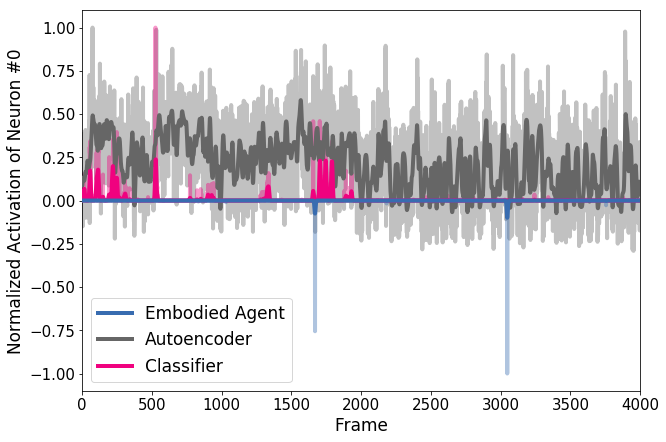

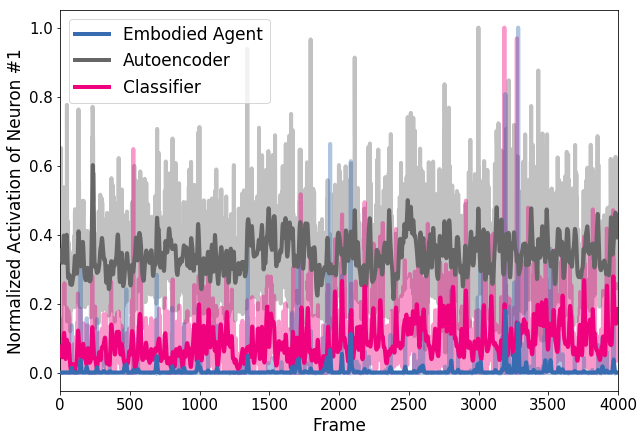

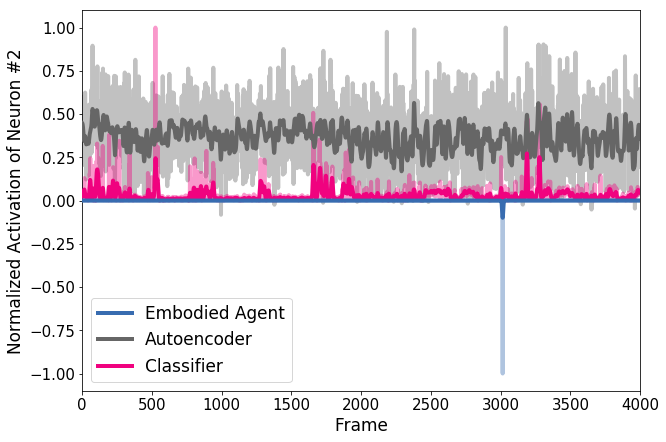

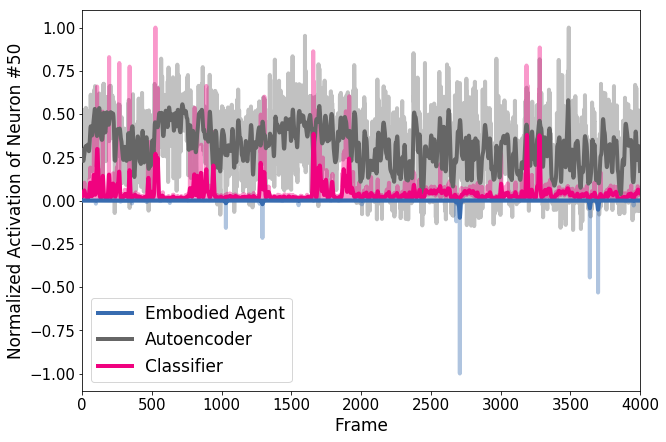

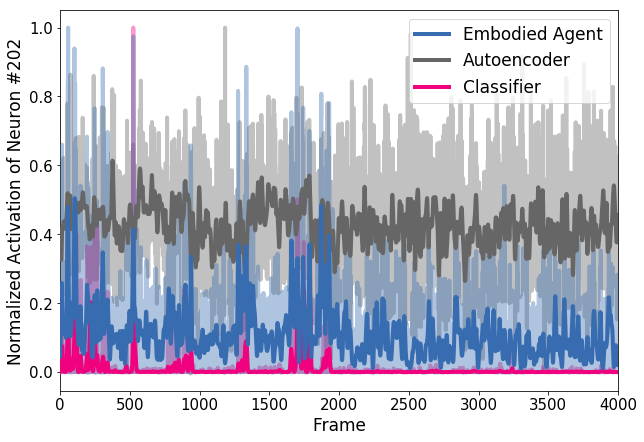

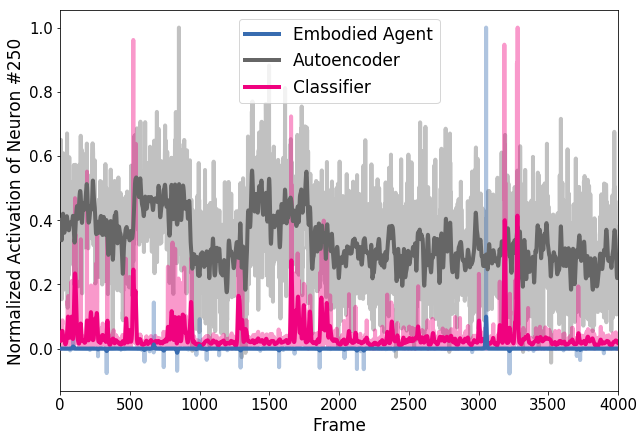

In [7]:
for n in [0,1,2,50,202,250]:
    plt.figure(figsize=(10,7))
    ysmoothedA = gaussian_filter1d(encA[:,n]/np.max(np.abs(encA[:,n])), sigma=4)
    plt.plot(ysmoothedA,color=sns.color_palette("Accent", n_colors=8)[4],lw=4,zorder=6)

    ysmoothedAE = gaussian_filter1d(encAE[:,n]/np.max(np.abs(encAE[:,n])), sigma=4)
    plt.plot(ysmoothedAE,color=sns.color_palette("Accent", n_colors=8)[7],lw=4,zorder=4)

    ysmoothedC = gaussian_filter1d(encC[:,n]/np.max(np.abs(encC[:,n])), sigma=4)
    plt.plot(ysmoothedC,color=sns.color_palette("Accent", n_colors=8)[5],lw=4,zorder=4)

    plt.plot(encA[:,n]/np.max(np.abs(encA[:,n])),color=sns.color_palette("Accent", n_colors=8)[4],lw=4,zorder=3,alpha=0.4)
    plt.plot(encAE[:,n]/np.max(np.abs(encAE[:,n])),color=sns.color_palette("Accent", n_colors=8)[7],lw=4,alpha=0.4)
    plt.plot(encC[:,n]/np.max(np.abs(encC[:,n])),color=sns.color_palette("Accent", n_colors=8)[5],lw=4,alpha=0.4)

    plt.xlim([0,4000])
    plt.legend(['Embodied Agent','Autoencoder','Classifier'],fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Frame',fontsize=17)
    plt.ylabel('Normalized Activation of Neuron #'+str(n),fontsize=17)
    #plt.show()
    plt.savefig(figure_path+'NeuronActs/ActN'+str(n)+'.jpeg', bbox_inches='tight', dpi=300)


## Meaningfulness of Activations
### K-Means
#### Create Clusterings

In [56]:
num_cluster = 6
kmeansA = KMeans(n_clusters=num_cluster, random_state=0).fit(encA)
clusterA = kmeansA.predict(encA)

kmeansAE = KMeans(n_clusters=num_cluster, random_state=0).fit(encAE)
clusterAE = kmeansAE.predict(encAE)

kmeansC = KMeans(n_clusters=num_cluster, random_state=0).fit(encC)
clusterC = kmeansC.predict(encC)

#### Variance within Clusters

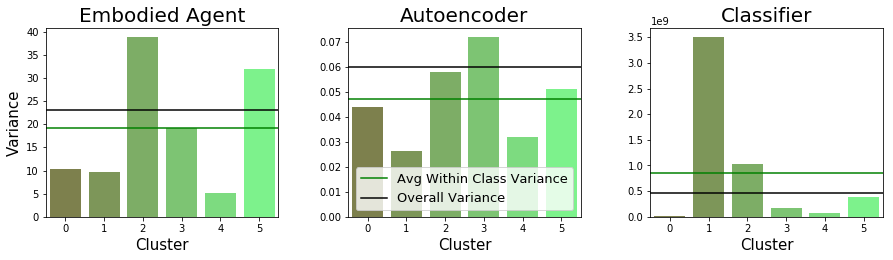

In [57]:

_,_,BA,WA = getClusterVariance(clusterA,encA,num_cluster)
_,_,BAE,WAE = getClusterVariance(clusterAE,encAE,num_cluster)
_,_,BC,WC = getClusterVariance(clusterC,encC,num_cluster)


plt.figure(figsize=(15,4))
plt.subplots_adjust(top=0.78,wspace=0.3)

plt.subplot(1,3,1)
plt.title('Embodied Agent',fontsize=20)
plt.bar(np.linspace(0,num_cluster-1,num_cluster),np.array(WA),color=[(0.49, 0.5+c*0.09, 0.3 + c*0.05)for c in range(6)])
plt.plot([-1,num_cluster],[np.mean(np.array(WA)),np.mean(np.array(WA))],color='green')
plt.plot([-1,num_cluster],[BA,BA],color='black')
plt.xlim([-0.5,num_cluster-0.5])
#plt.legend(['Avg Within Class Variance','Overall Variance'],fontsize=10)
plt.xlabel('Cluster',fontsize=15)
plt.ylabel('Variance',fontsize=15)

plt.subplot(1,3,2)
plt.title('Autoencoder',fontsize=20)
plt.bar(np.linspace(0,num_cluster-1,num_cluster),np.array(WAE),color=[(0.49, 0.5+c*0.09, 0.3 + c*0.05)for c in range(6)])
plt.plot([-1,num_cluster],[np.mean(np.array(WAE)),np.mean(np.array(WAE))],color='green')
plt.plot([-1,num_cluster],[BAE,BAE],color='black')
plt.xlim([-0.5,num_cluster-0.5])
plt.legend(['Avg Within Class Variance','Overall Variance'],fontsize=13,loc = 8)
plt.xlabel('Cluster',fontsize=15)
#plt.ylabel('Variance',fontsize=15)

plt.subplot(1,3,3)
plt.title('Classifier',fontsize=20)
plt.bar(np.linspace(0,num_cluster-1,num_cluster),np.array(WC),color=[(0.49, 0.5+c*0.09, 0.3 + c*0.05)for c in range(6)])
plt.plot([-1,num_cluster],[np.mean(np.array(WC)),np.mean(np.array(WC))],color='green')
plt.plot([-1,num_cluster],[BC,BC],color='black')
plt.xlim([-0.5,num_cluster-0.5])
#plt.legend(['Avg Within Class Variance','Overall Variance'],fontsize=10)
plt.xlabel('Cluster',fontsize=15)
#plt.ylabel('Variance',fontsize=15)
#plt.show()
plt.savefig(figure_path+'ClusterVar'+str(num_cluster)+'.eps', bbox_inches='tight',dpi=300)

#### Distribution of Frames in Clusters

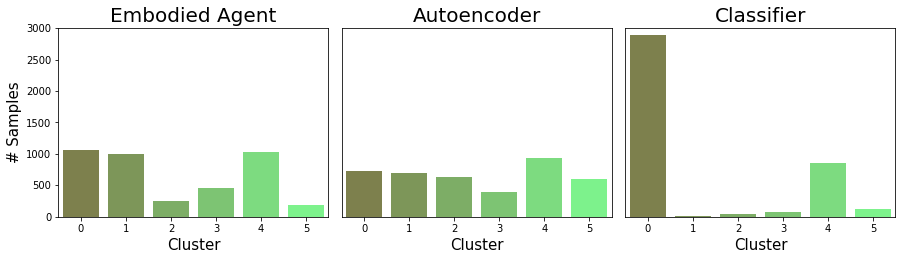

In [67]:
plt.figure(figsize=(15,4))
plt.subplots_adjust(top=0.78,wspace=0.05)

plt.subplot(1,3,1)
plt.title('Embodied Agent',fontsize=20)
hA = np.histogram(clusterA,bins=np.linspace(-0.5,num_cluster-0.5,num_cluster+1))
plt.bar(np.linspace(0,5,6),hA[0],color=[(0.49, 0.5+c*0.09, 0.3 + c*0.05)for c in range(6)])
plt.xlim([-0.5,num_cluster-0.5])
plt.ylim([0,3000])
plt.xlabel('Cluster',fontsize=15)
plt.ylabel('# Samples',fontsize=15)

plt.subplot(1,3,2)
plt.title('Autoencoder',fontsize=20)
hAE = np.histogram(clusterAE,bins=np.linspace(-0.5,num_cluster-0.5,num_cluster+1))
plt.bar(np.linspace(0,5,6),hAE[0],color=[(0.49, 0.5+c*0.09, 0.3 + c*0.05)for c in range(6)])
plt.xlim([-0.5,num_cluster-0.5])
plt.ylim([0,3000])
plt.yticks([],[])
plt.xlabel('Cluster',fontsize=15)

plt.subplot(1,3,3)
plt.title('Classifier',fontsize=20)
hC = np.histogram(clusterC,bins=np.linspace(-0.5,num_cluster-0.5,num_cluster+1))
plt.bar(np.linspace(0,5,6),hC[0],color=[(0.49, 0.5+c*0.09, 0.3 + c*0.05)for c in range(6)])
plt.xlim([-0.5,num_cluster-0.5])
plt.ylim([0,3000])
plt.yticks([],[])
plt.xlabel('Cluster',fontsize=15)

#plt.show()
plt.savefig(figure_path+'ClusterCount'+str(num_cluster)+'.eps', bbox_inches='tight',dpi=300)

#### Correlations Between Actions and Clusters - Embodied Agent

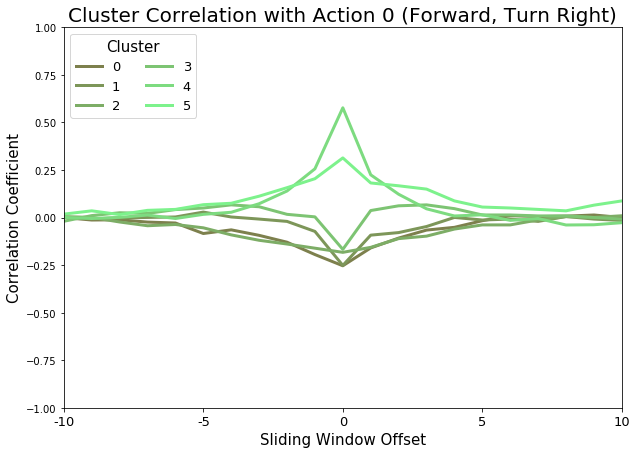

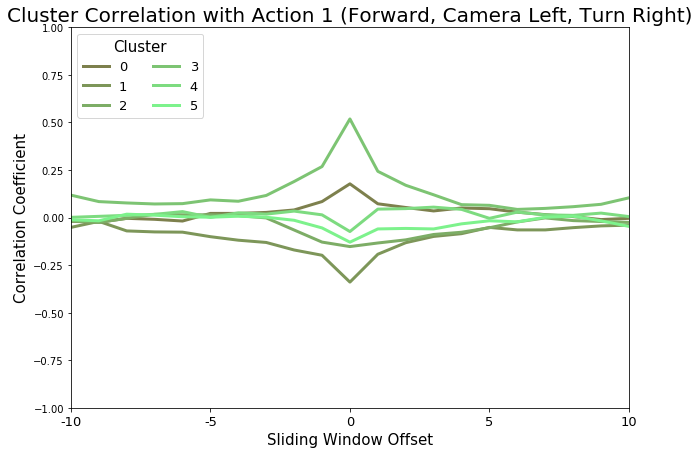

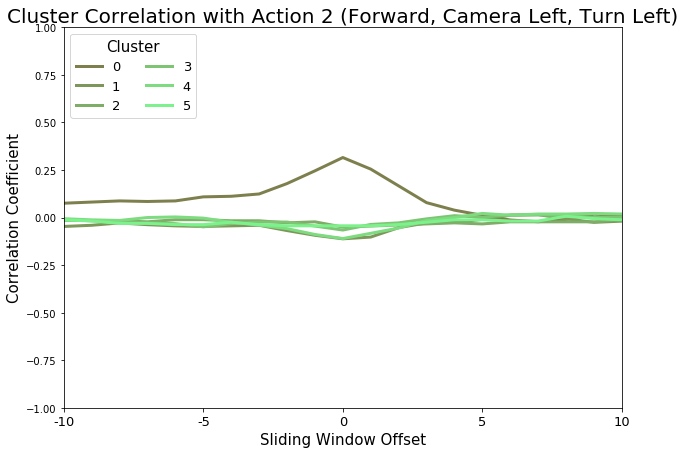

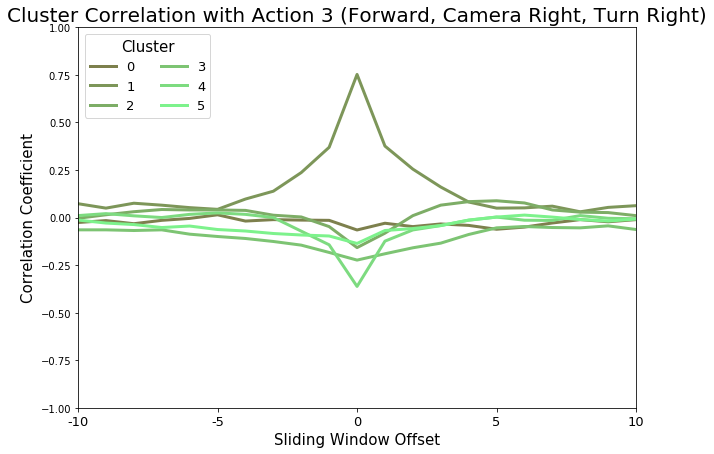

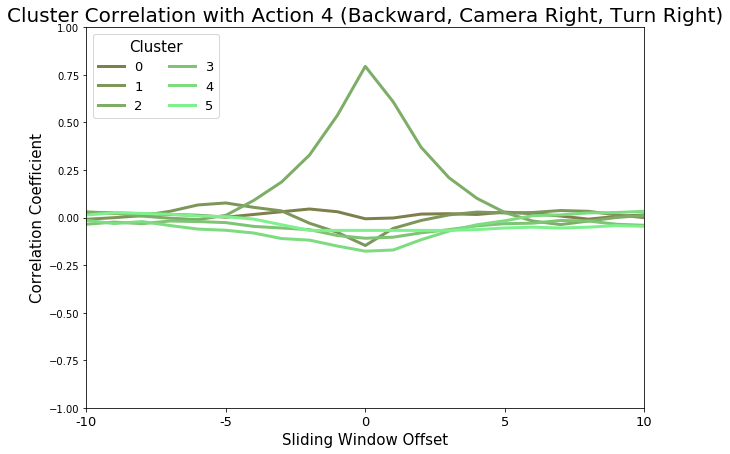

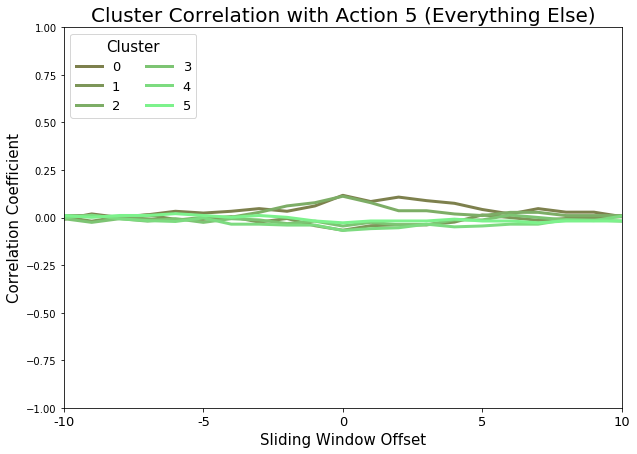

In [11]:
p = np.array(sns.color_palette("Accent", n_colors=8))[np.array([0,1,3,4,6,7])]
corVal=np.zeros((6,num_cluster))
cormaxA = 0
corminA = 0
for action in range(6):
    corrs = np.zeros((21,num_cluster))
    for c in range(num_cluster):
        for r in range(-10,11):
            a = np.roll(all_a_comb==action, r)
            corrs[r+10,c] = np.corrcoef((clusterA==c).astype(int),a)[1][0]
        if np.max(corrs[:,c])>cormaxA:cormaxA = np.max(corrs[:,c])
        if np.min(corrs[:,c])<corminA:corminA = np.min(corrs[:,c])
        corVal[action,c] = np.mean(corrs[8:13,c])
    plt.figure(figsize=(10,7))
    for c in range(num_cluster):
        #ysmoothed = gaussian_filter1d(corrs[:,c], sigma=0.5)
        plt.plot(corrs[:,c],linewidth=3,color=(0.49, 0.5+c*0.09, 0.3 + c*0.05))
    plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)
    plt.title('Cluster Correlation with Action '+str(action)+' ('+actions[action]+')',fontsize=20)
    plt.xlabel('Sliding Window Offset',fontsize=15)
    plt.ylabel('Correlation Coefficient',fontsize=15)
    plt.xticks([0,5,10,15,20],['-10','-5','0','5','10'],fontsize=13)
    plt.ylim([-1,1])
    plt.xlim([0,20])
    #plt.show()
    plt.savefig(figure_path+'C_A_Corrs/A_Corrcoef20_A'+str(action)+'.png', bbox_inches='tight')

In [12]:
dfA = pd.DataFrame(columns=['Action','cluster','correlation'])
for a in range(6):
    for c in range(num_cluster):
        dfA = dfA.append({'Action':actions[a],'cluster':int(c),'correlation':corVal[a,c]},ignore_index=True)

#### Correlations Between Actions and Clusters - Autoencoder

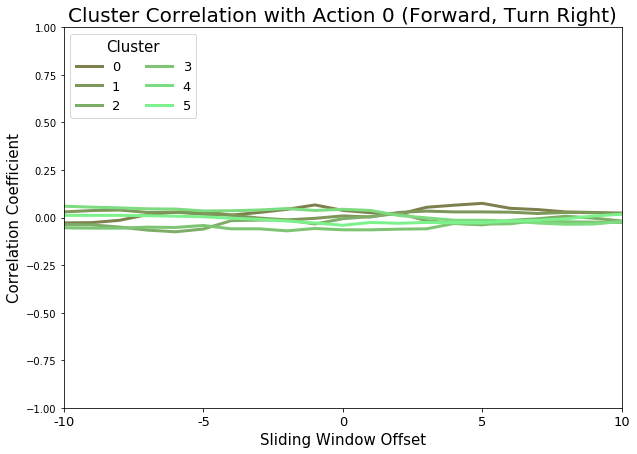

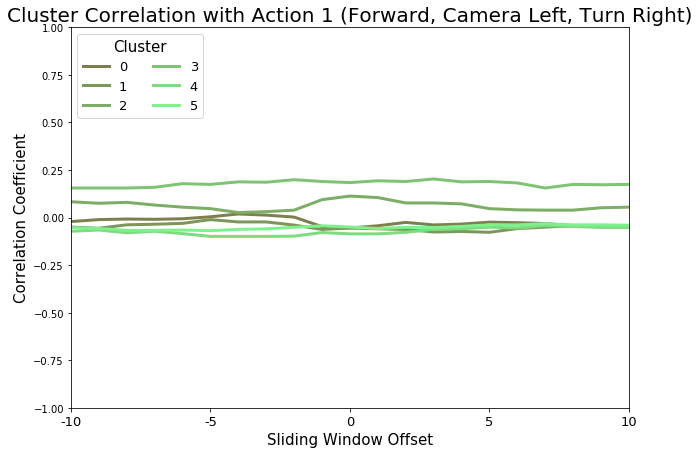

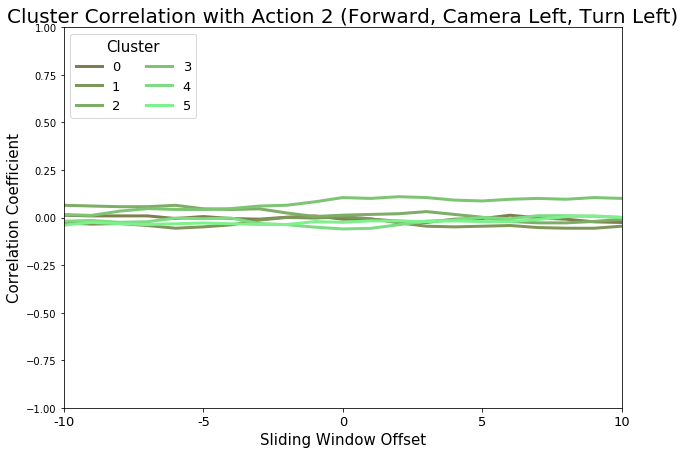

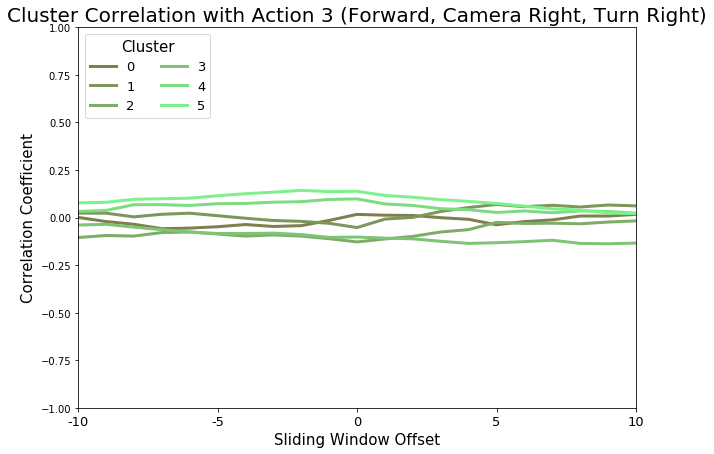

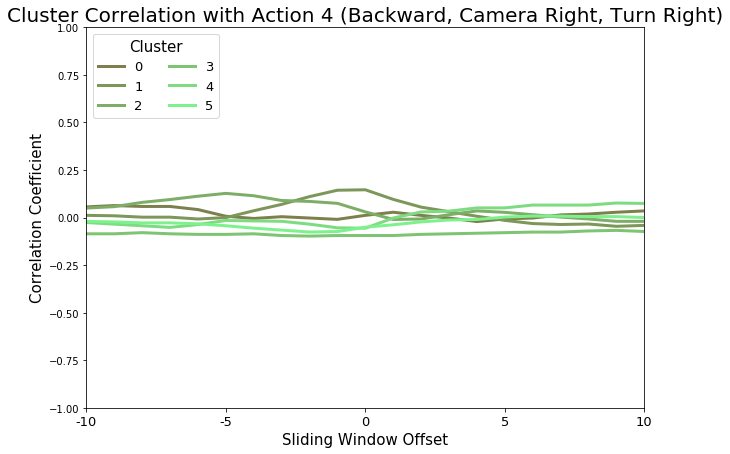

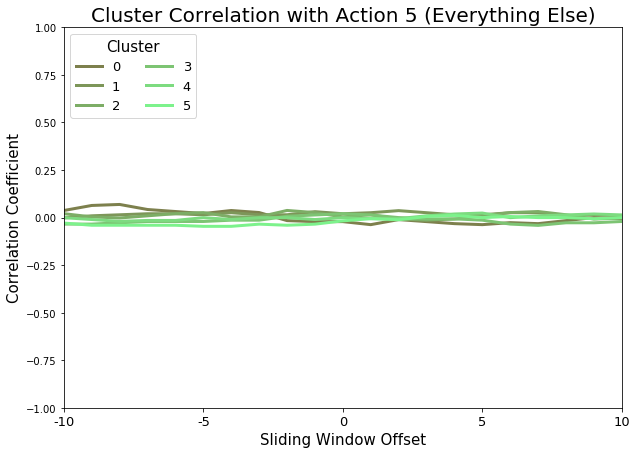

In [13]:
p = np.array(sns.color_palette("Accent", n_colors=8))[np.array([0,1,3,4,6,7])]
corValAE=np.zeros((6,num_cluster))
cormaxAE = 0
corminAE = 0
for action in range(6):
    corrs = np.zeros((21,num_cluster))
    for c in range(num_cluster):
        for r in range(-10,11):
            a = np.roll(all_a_comb==action, r)
            corrs[r+10,c] = np.corrcoef((clusterAE==c).astype(int),a)[1][0]
        if np.max(corrs[:,c])>cormaxAE:cormaxAE = np.max(corrs[:,c])
        if np.min(corrs[:,c])<corminAE:corminAE = np.min(corrs[:,c])
        corValAE[action,c] = np.mean(corrs[8:13,c])
    plt.figure(figsize=(10,7))
    for c in range(num_cluster):
        #ysmoothed = gaussian_filter1d(corrs[:,c], sigma=0.5)
        plt.plot(corrs[:,c],linewidth=3,color=(0.49, 0.5+c*0.09, 0.3 + c*0.05))
    plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)
    plt.title('Cluster Correlation with Action '+str(action)+' ('+actions[action]+')',fontsize=20)
    plt.xlabel('Sliding Window Offset',fontsize=15)
    plt.ylabel('Correlation Coefficient',fontsize=15)
    plt.xticks([0,5,10,15,20],['-10','-5','0','5','10'],fontsize=13)
    plt.ylim([-1,1])
    plt.xlim([0,20])
    #plt.show()
    plt.savefig(figure_path+'C_A_Corrs/AE_Corrcoef20_A'+str(action)+'.png', bbox_inches='tight')

In [14]:
dfAE = pd.DataFrame(columns=['Action','cluster','correlation'])
for a in range(6):
    for c in range(num_cluster):
        dfAE = dfAE.append({'Action':actions[a],'cluster':int(c),'correlation':corValAE[a,c]},ignore_index=True)

#### Correlations Between Actions and Clusters - Classifier

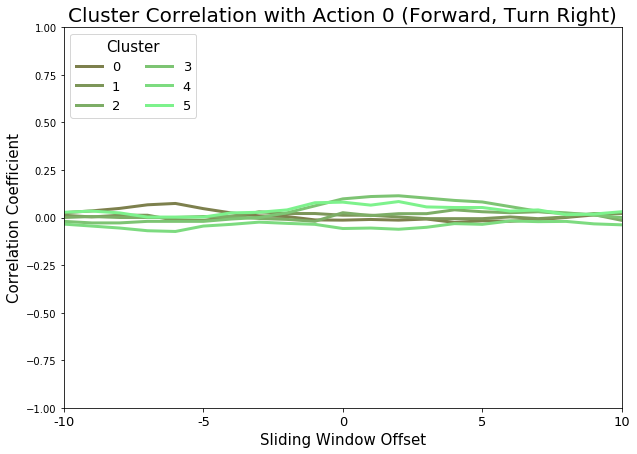

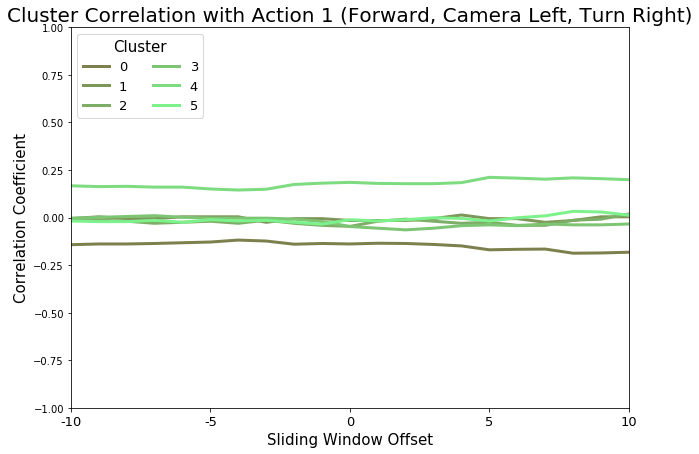

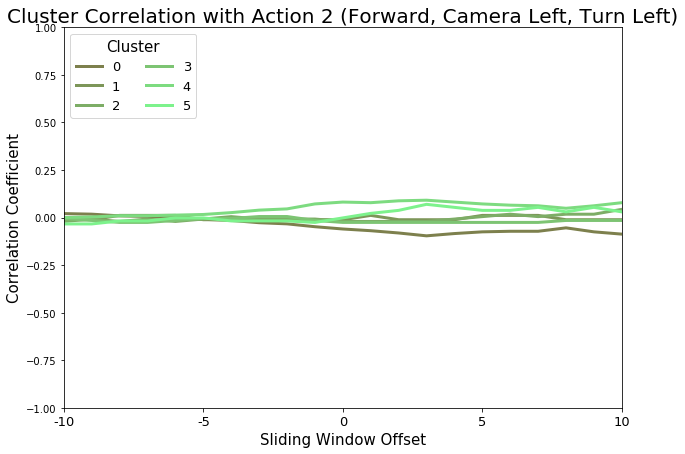

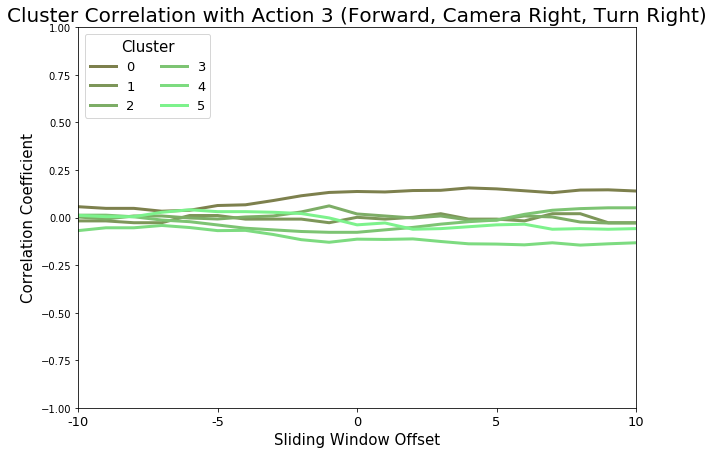

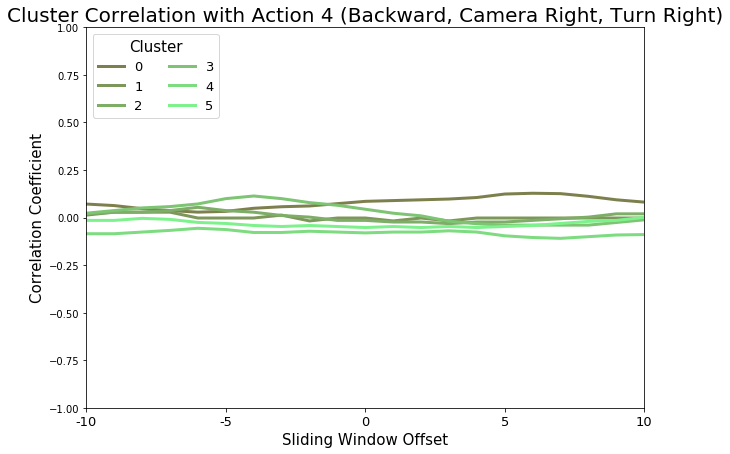

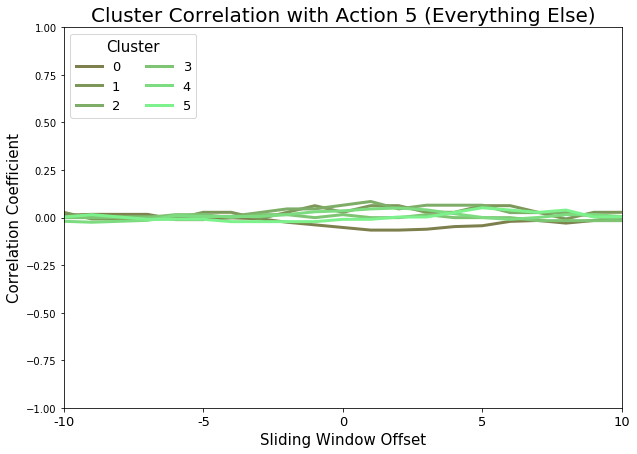

In [15]:
p = np.array(sns.color_palette("Accent", n_colors=8))[np.array([0,1,3,4,6,7])]
corValC=np.zeros((6,num_cluster))
cormaxC = 0
corminC = 0
for action in range(6):
    corrs = np.zeros((21,num_cluster))
    for c in range(num_cluster):
        for r in range(-10,11):
            a = np.roll(all_a_comb==action, r)
            corrs[r+10,c] = np.corrcoef((clusterC==c).astype(int),a)[1][0]
        if np.max(corrs[:,c])>cormaxC:cormaxC = np.max(corrs[:,c])
        if np.min(corrs[:,c])<corminC:corminC = np.min(corrs[:,c])
        corValC[action,c] = np.mean(corrs[8:13,c])
    plt.figure(figsize=(10,7))
    for c in range(num_cluster):
        #ysmoothed = gaussian_filter1d(corrs[:,c], sigma=0.5)
        plt.plot(corrs[:,c],linewidth=3,color=(0.49, 0.5+c*0.09, 0.3 + c*0.05))
    plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)
    plt.title('Cluster Correlation with Action '+str(action)+' ('+actions[action]+')',fontsize=20)
    plt.xlabel('Sliding Window Offset',fontsize=15)
    plt.ylabel('Correlation Coefficient',fontsize=15)
    plt.xticks([0,5,10,15,20],['-10','-5','0','5','10'],fontsize=13)
    plt.ylim([-1,1])
    plt.xlim([0,20])
    #plt.show()
    plt.savefig(figure_path+'C_A_Corrs/C_Corrcoef20_A'+str(action)+'.png', bbox_inches='tight')

In [16]:
dfC = pd.DataFrame(columns=['Action','cluster','correlation'])
for a in range(6):
    for c in range(num_cluster):
        dfC = dfC.append({'Action':actions[a],'cluster':int(c),'correlation':corValC[a,c]},ignore_index=True)

#### Correlations Between Actions and Clusters - Comparison Example

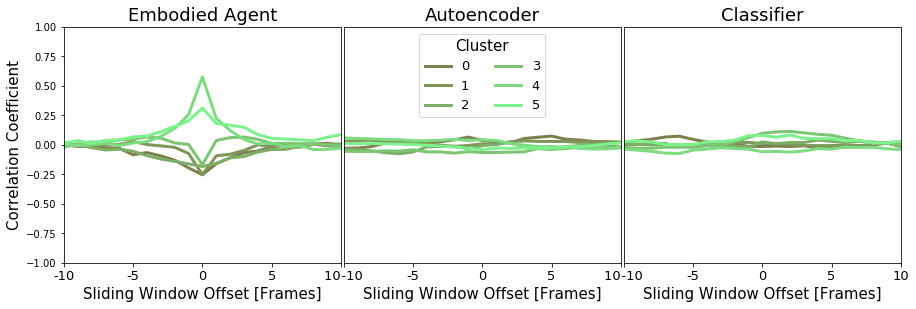

In [17]:
action = 0
fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(top=0.78,wspace=0.01)

plt.subplot(1,3,1)
corrsA = np.zeros((21,num_cluster))
for c in range(num_cluster):
    for r in range(-10,11):
        a = np.roll(all_a_comb==action, r)
        corrsA[r+10,c] = np.corrcoef((clusterA==c).astype(int),a)[1][0]
for c in range(num_cluster):
    plt.plot(corrsA[:,c],linewidth=3,color=(0.49, 0.5+c*0.09, 0.3 + c*0.05))
#plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)
plt.title('Embodied Agent',fontsize=18)
plt.xlabel('Sliding Window Offset [Frames]',fontsize=15)
plt.ylabel('Correlation Coefficient',fontsize=15)
plt.xticks([0,5,10,15,20],['    -10','-5','0','5','10'],fontsize=13)
plt.xticks([0,5,10,15,20],['-10','-5','0','5','10    '],fontsize=13)
plt.ylim([-1,1])
plt.xlim([0,20])

plt.subplot(1,3,2)
corrsAE = np.zeros((21,num_cluster))
for c in range(num_cluster):
    for r in range(-10,11):
        a = np.roll(all_a_comb==action, r)
        corrsAE[r+10,c] = np.corrcoef((clusterAE==c).astype(int),a)[1][0]
for c in range(num_cluster):
    plt.plot(corrsAE[:,c],linewidth=3,color=(0.49, 0.5+c*0.09, 0.3 + c*0.05))
plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=9,ncol=2)
plt.title('Autoencoder',fontsize=18)
plt.xlabel('Sliding Window Offset [Frames]',fontsize=15)
plt.yticks([],[])
plt.xticks([0,5,10,15,20],['    -10','-5','0','5','10    '],fontsize=13)
plt.ylim([-1,1])
plt.xlim([0,20])

plt.subplot(1,3,3)
corrsC = np.zeros((21,num_cluster))
for c in range(num_cluster):
    for r in range(-10,11):
        a = np.roll(all_a_comb==action, r)
        corrsC[r+10,c] = np.corrcoef((clusterC==c).astype(int),a)[1][0]
for c in range(num_cluster):
    plt.plot(corrsC[:,c],linewidth=3,color=(0.49, 0.5+c*0.09, 0.3 + c*0.05))
#plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)
plt.title('Classifier',fontsize=18)
plt.xlabel('Sliding Window Offset [Frames]',fontsize=15)
#plt.ylabel('Correlation Coefficient',fontsize=15)
plt.xticks([0,5,10,15,20],['    -10','-5','0','5','10'],fontsize=13)
plt.yticks([],[])
plt.ylim([-1,1])
plt.xlim([0,20])

#plt.suptitle('Correlation in 20 Frame Window Around Action for \nAction = '+str(actions[action]),fontsize=20)
#plt.legend(fontsize=15,bbox_to_anchor=(1.15, 0.8), loc=2)
#plt.show()
plt.savefig(figure_path+'Corrcoef_Comparison_Expl_A'+str(action)+'.eps', bbox_inches='tight',dpi=300)

#### Correlations Between Actions and Clusters - Overall Comparison

In [18]:
print("Embodied Agent:\nMaximum Correlation: "+str(np.round(cormaxA,3))+" Minimum Correlation: "+str(np.round(corminA,3)))
print("Autoencoder:\nMaximum Correlation: "+str(np.round(cormaxAE,3))+" Minimum Correlation: "+str(np.round(corminAE,3)))
print("Classifier:\nMaximum Correlation: "+str(np.round(cormaxC,3))+" Minimum Correlation: "+str(np.round(corminC,3)))

Embodied Agent:
Maximum Correlation: 0.795 Minimum Correlation: -0.362
Autoencoder:
Maximum Correlation: 0.203 Minimum Correlation: -0.138
Classifier:
Maximum Correlation: 0.211 Minimum Correlation: -0.187


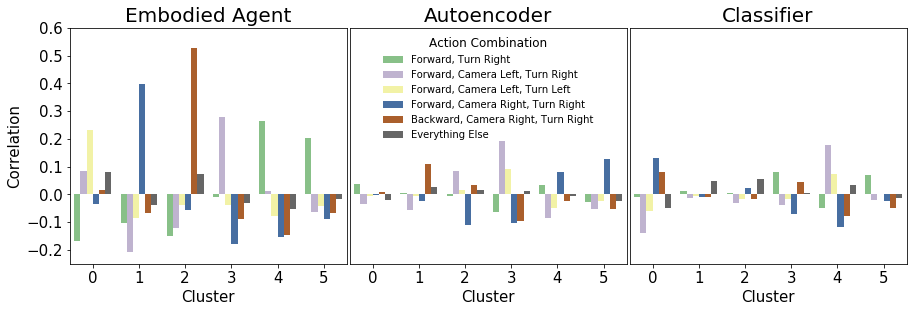

In [19]:
p = np.array(sns.color_palette("Accent", n_colors=8))[np.array([0,1,3,4,6,7])]

fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(top=0.78,wspace=0.01)

plt.subplot(1,3,1)
ax = sns.barplot(x="cluster", y="correlation", hue="Action", data=dfA,palette=p)
ax.get_legend().remove()
plt.title('Embodied Agent',fontsize=20)
plt.ylabel('Correlation',fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-0.25,0.6)
plt.xlabel("Cluster",fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(1,3,2)
ax2 = sns.barplot(x="cluster", y="correlation", hue="Action", data=dfAE,palette=p)
#ax2.get_legend().remove()
ax2.legend(fontsize=10,frameon=False,title='Action Combination',title_fontsize=12,loc=9)
plt.title('Autoencoder',fontsize=20)
plt.yticks([],[])
plt.ylim(-0.25,0.6)
plt.ylabel('')
plt.xlabel("Cluster",fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(1,3,3)
ax3 = sns.barplot(x="cluster", y="correlation", hue="Action", data=dfC,palette=p)
#ax3.legend(fontsize=10,frameon=False,title='Action Combination',title_fontsize=12)
ax3.get_legend().remove()
plt.title('Classifier',fontsize=20)
plt.yticks([],[])
plt.ylim(-0.25,0.6)
plt.ylabel('')

plt.ylabel('')
plt.xlabel("Cluster",fontsize=15)
plt.xticks(fontsize=15)

#plt.suptitle('Avg. Correlation in 10 Frame Window Around Action with Cluster',fontsize=22)
#plt.show()
plt.savefig(figure_path+'Corrcoef_Comparison.eps', bbox_inches='tight',dpi=300)

#### Correlations Between Actions and Clusters - Sum of Squared Correlations

In [20]:
sosA = np.zeros(num_cluster)#sum of squares of correlations in one cluster
for c in range(num_cluster):
    sosA[c] = np.sum(np.square(corVal[:,c]))
    
sosAE = np.zeros(num_cluster)
for c in range(num_cluster):
    sosAE[c] = np.sum(np.square(corValAE[:,c]))

sosC = np.zeros(num_cluster)
for c in range(num_cluster):
    sosC[c] = np.sum(np.square(corValC[:,c]))

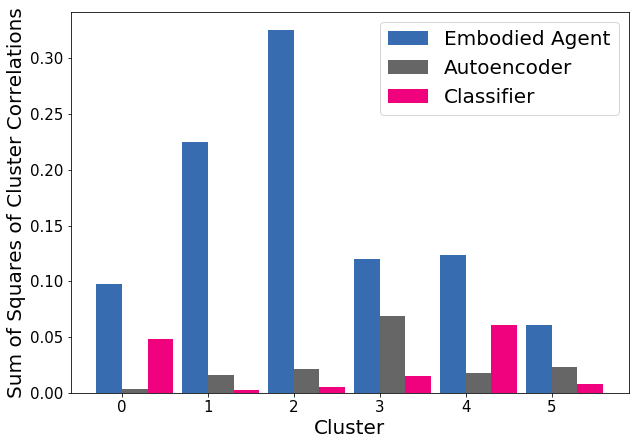

In [21]:
plt.figure(figsize=(10,7))
plt.bar(np.linspace(-0.15,4.85,6),sosA,width=0.3,color=sns.color_palette("Accent", n_colors=8)[4])
plt.bar(np.linspace(0.15,5.15,6),sosAE,width=0.3,color=sns.color_palette("Accent", n_colors=8)[7])
plt.bar(np.linspace(0.45,5.45,6),sosC,width=0.3,color=sns.color_palette("Accent", n_colors=8)[5])

#plt.title('Sum of Squares of Correlations\nBetween Actions and Cluster',fontsize=25)
plt.xlabel('Cluster',fontsize=20)
plt.ylabel('Sum of Squares of Cluster Correlations',fontsize=20)
plt.legend(['Embodied Agent','Autoencoder','Classifier'],fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.show()
plt.savefig(figure_path+'Corrcoef_sum_squares.eps', bbox_inches='tight',dpi=300)

In [22]:
print('Overall sum of squares: Embodied Agent = '+str(np.round(np.sum(sosA),3))+' Autoencoder = '+str(np.round(np.sum(sosAE),3))+' Classifier = '+str(np.round(np.sum(sosC),3)))

Overall sum of squares: Embodied Agent = 0.952 Autoencoder = 0.151 Classifier = 0.141


#### Correlations Between Level Doors and Clusters

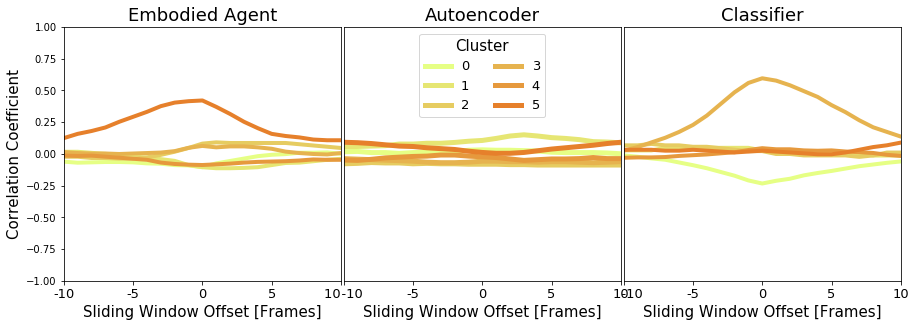

In [23]:
l_doors = label_test==6
l_doors = l_doors.astype(int)

fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(top=0.83,wspace=0.01)

plt.subplot(1,3,1)
corrsA = np.zeros((21,num_cluster))
for c in range(num_cluster):
    for r in range(-10,11):
        a = np.roll(l_doors, r)
        corrsA[r+10,c] = np.corrcoef((clusterA==c).astype(int),a)[1][0]
for c in range(num_cluster):
    r = num_cluster-c
    plt.plot(corrsA[:,c],linewidth=4,color=(0.9, 0.4+r*0.1, 0.1 + r*0.07))

#plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)
plt.title('Embodied Agent',fontsize=18)
plt.xlabel('Sliding Window Offset [Frames]',fontsize=15)
plt.ylabel('Correlation Coefficient',fontsize=15)
plt.xticks([0,5,10,15,20],['-10','-5','0','5','10    '],fontsize=13)
plt.ylim([-1,1])
plt.xlim([0,20])

plt.subplot(1,3,2)
corrsAE = np.zeros((21,num_cluster))
for c in range(num_cluster):
    for r in range(-10,11):
        a = np.roll(l_doors, r)
        corrsAE[r+10,c] = np.corrcoef((clusterAE==c).astype(int),a)[1][0]
for c in range(num_cluster):
    r = num_cluster-c
    plt.plot(corrsAE[:,c],linewidth=5,color=(0.9, 0.4+r*0.1, 0.1 + r*0.07))

plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=9,ncol=2)
plt.title('Autoencoder',fontsize=18)
plt.xlabel('Sliding Window Offset [Frames]',fontsize=15)
#plt.ylabel('Correlation Coefficient',fontsize=15)
plt.xticks([0,5,10,15,20],['    -10','-5','0','5','10'],fontsize=13)
plt.yticks([],[])
plt.ylim([-1,1])
plt.xlim([0,20])

plt.subplot(1,3,3)
corrsC = np.zeros((21,num_cluster))
for c in range(num_cluster):
    for r in range(-10,11):
        a = np.roll(l_doors, r)
        corrsC[r+10,c] = np.corrcoef((clusterC==c).astype(int),a)[1][0]
for c in range(num_cluster):
    r = num_cluster-c
    plt.plot(corrsC[:,c],linewidth=4,color=(0.9, 0.4+r*0.1, 0.1 + r*0.07))
#plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)

plt.title('Classifier',fontsize=18)
plt.xlabel('Sliding Window Offset [Frames]',fontsize=15)
#plt.ylabel('Correlation Coefficient',fontsize=15)
plt.xticks([0,5,10,15,20],['    -10','-5','0','5','10'],fontsize=13)
plt.yticks([],[])
plt.ylim([-1,1])
plt.xlim([0,20])


#plt.suptitle('Correlation with Level Doors in the Visual Input',fontsize=20)
#plt.legend(fontsize=15,bbox_to_anchor=(1.15, 0.8), loc=2)
#plt.show()
plt.savefig(figure_path+'Corrcoef_Comparison_Doors.eps', bbox_inches='tight',dpi=300)

In [24]:
print("Embodied Agent:\nMaximum Correlation: "+str(np.round(np.max(corrsA),3))+" Minimum Correlation: "+str(np.round(np.min(corrsA),3)))
print("Autoencoder:\nMaximum Correlation: "+str(np.round(np.max(corrsAE),3))+" Minimum Correlation: "+str(np.round(np.min(corrsAE),3)))
print("Classifier:\nMaximum Correlation: "+str(np.round(np.max(corrsC),3))+" Minimum Correlation: "+str(np.round(np.min(corrsC),3)))

Embodied Agent:
Maximum Correlation: 0.421 Minimum Correlation: -0.113
Autoencoder:
Maximum Correlation: 0.15 Minimum Correlation: -0.088
Classifier:
Maximum Correlation: 0.596 Minimum Correlation: -0.233


### T-SNE
#### Create Mapping into 2D Space

In [25]:
tsneA = TSNE(n_components=2,perplexity=70,random_state=0).fit_transform(encA)
tsneAE = TSNE(n_components=2,perplexity=70,random_state=0).fit_transform(encAE)
tsneC = TSNE(n_components=2,perplexity=70,random_state=0).fit_transform(encC)

#### T-SNE Colored by Image Content - Embodied Agent

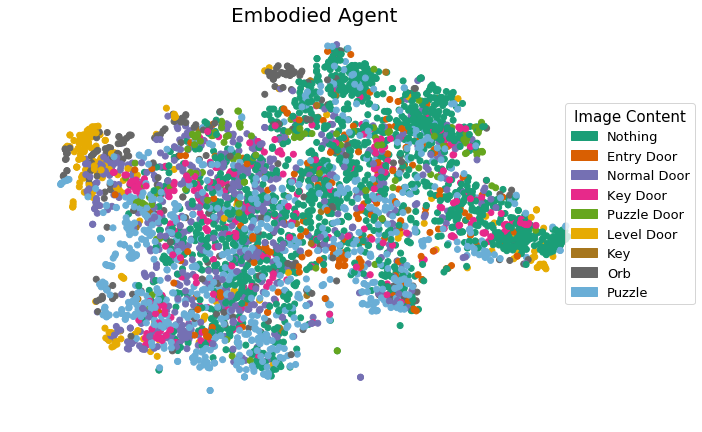

In [26]:
top = plt.cm.get_cmap('Dark2')
bottom = plt.cm.get_cmap('Blues')

newcolors = np.vstack((top(np.linspace(0, 1, 8)),
                       bottom(np.linspace(0.5, 1, 1))))
cmapnew = mpl.colors.ListedColormap(newcolors, name='GreyBlue')

sem_lab = ['Nothing','Entry Door','Normal Door',
           'Key Door','Puzzle Door','Level Door','Key','Orb','Puzzle']

plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Embodied Agent', fontsize=20)
im1 = plt.scatter(tsneA[:,0],tsneA[:,1],c=label_test,cmap=cmapnew)
values = np.linspace(1,9,9)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=sem_lab[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.95, 0.8), loc=2, borderaxespad=0. , title='Image Content',title_fontsize=15,fontsize=13)

plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_semantic_A.eps', bbox_inches='tight',dpi=300)

#### T-SNE Colored by Image Content - Autoencoder

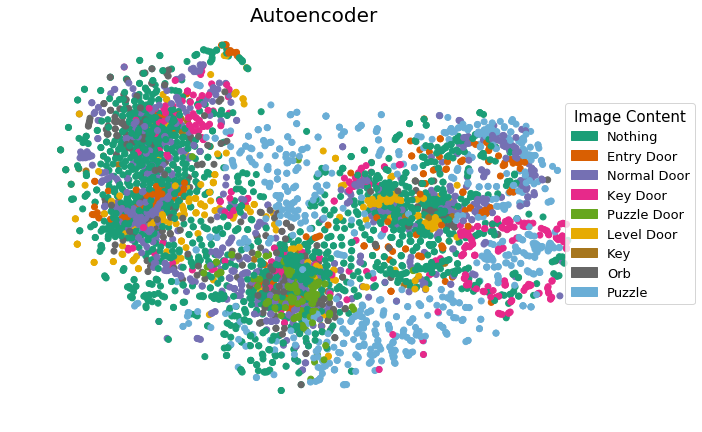

In [27]:
top = plt.cm.get_cmap('Dark2')
bottom = plt.cm.get_cmap('Blues')

newcolors = np.vstack((top(np.linspace(0, 1, 8)),
                       bottom(np.linspace(0.5, 1, 1))))
cmapnew = mpl.colors.ListedColormap(newcolors, name='GreyBlue')

sem_lab = ['Nothing','Entry Door','Normal Door',
           'Key Door','Puzzle Door','Level Door','Key','Orb','Puzzle']

plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Autoencoder', fontsize=20)
im1 = plt.scatter(tsneAE[:,0],tsneAE[:,1],c=label_test,cmap=cmapnew)
values = np.linspace(1,9,9)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=sem_lab[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.95, 0.8), loc=2, borderaxespad=0. , title='Image Content',title_fontsize=15,fontsize=13)

plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_semantic_AE.eps', bbox_inches='tight',dpi=300)

#### T-SNE Colored by Image Content - Classifier

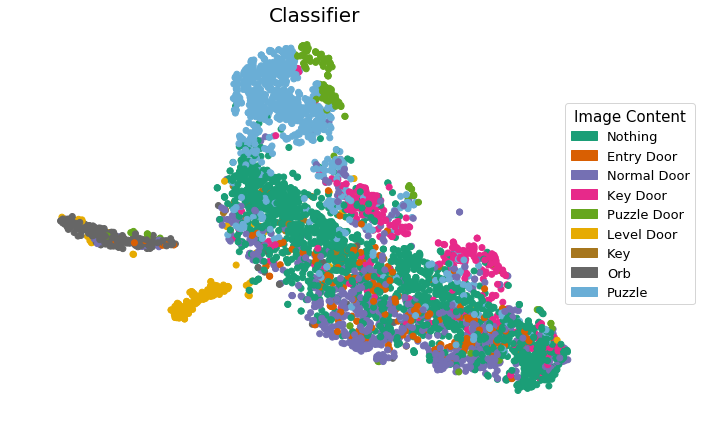

In [28]:
top = plt.cm.get_cmap('Dark2')
bottom = plt.cm.get_cmap('Blues')

newcolors = np.vstack((top(np.linspace(0, 1, 8)),
                       bottom(np.linspace(0.5, 1, 1))))
cmapnew = mpl.colors.ListedColormap(newcolors, name='GreyBlue')

sem_lab = ['Nothing','Entry Door','Normal Door',
           'Key Door','Puzzle Door','Level Door','Key','Orb','Puzzle']

plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Classifier', fontsize=20)
im1 = plt.scatter(tsneC[:,0],tsneC[:,1],c=label_test,cmap=cmapnew)
values = np.linspace(1,9,9)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=sem_lab[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.95, 0.8), loc=2, borderaxespad=0. , title='Image Content',title_fontsize=15,fontsize=13)

plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_semantic_C.eps', bbox_inches='tight',dpi=300)

#### T-SNE Colored by Action - Preprocessing

In [29]:
label_test = np.array(hand_l['Label'])
edgeWs = np.array(hand_l['Label'])
edgeWs[edgeWs == 0]=0
edgeWs[edgeWs == 1]=0
edgeWs[edgeWs == 2]=0
edgeWs[edgeWs == 3]=0
edgeWs[edgeWs == 4]=0
edgeWs[edgeWs == 5]=0
edgeWs[edgeWs == 6]=1
edgeWs[edgeWs == 7]=0
edgeWs[edgeWs == 8]=0
edgeWs[edgeWs == 9]=0

edgeCs = np.array(hand_l['Label'])
edgeCs = edgeCs.astype(str)
edgeCs[edgeCs=='0'] = 'b'
edgeCs[edgeCs=='1'] = 'b'
edgeCs[edgeCs=='2'] = 'b'
edgeCs[edgeCs=='3'] = 'green'
edgeCs[edgeCs=='4'] = 'firebrick'
edgeCs[edgeCs=='5'] = 'purple'
edgeCs[edgeCs=='6'] = 'r'
edgeCs[edgeCs=='7'] = 'yellow'
edgeCs[edgeCs=='8'] = 'darkblue'
edgeCs[edgeCs=='9'] = 'b'

newOrder = np.append(np.where(edgeWs==0),np.where(edgeWs!=0))#to plot door frames on top (better visibility)
edgeWs[newOrder]

act_lab = ['Forward, Turn Right','Forward, Camera Left, Turn Right','Forward, Camera Left, Turn Left',
           'Forward, Camera Right, Turn Right','Backward, Camera Right, Turn Right','Everything Else']

#### T-SNE Colored by Action - Embodied Agent

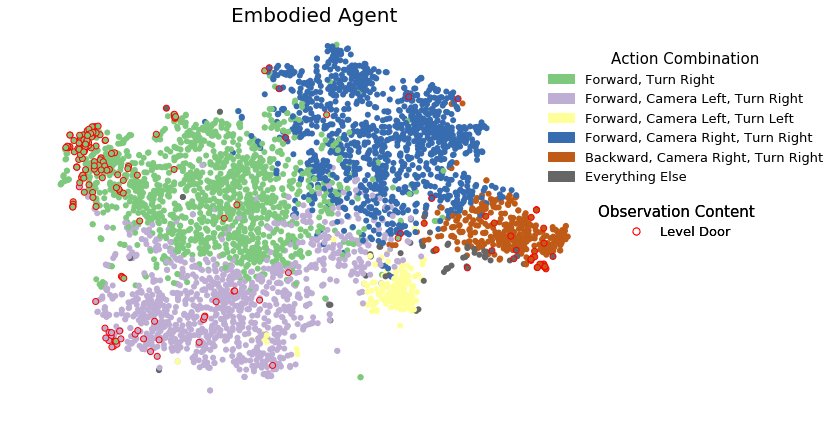

In [30]:
fig = plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Embodied Agent', fontsize=20)
im1 = plt.scatter(tsneA[newOrder,0],tsneA[newOrder,1],c=all_a_comb[newOrder],cmap='Accent',edgecolors=edgeCs[newOrder],linewidths =edgeWs[newOrder])
values = np.linspace(0,5,6)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=act_lab[i] ) for i in range(len(values)) ]
l1 = plt.legend(handles=patches, bbox_to_anchor=(0.91, 0.95), loc=2, borderaxespad=0. , title='Action Combination',title_fontsize=15,fontsize=13,frameon=False)

line1 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="red")
line2 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="white")
l2 = plt.legend((line1,line2),('Level Door',''), bbox_to_anchor=(1, 0.55),numpoints=1, loc=2,fontsize=13,title="Observation Content",title_fontsize=15,frameon=False, borderaxespad=0.)

fig.add_artist(l1)
fig.add_artist(l2)

plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_actions_A.eps', bbox_inches='tight',dpi=300)

#### T-SNE Colored by Action - Autoencoder

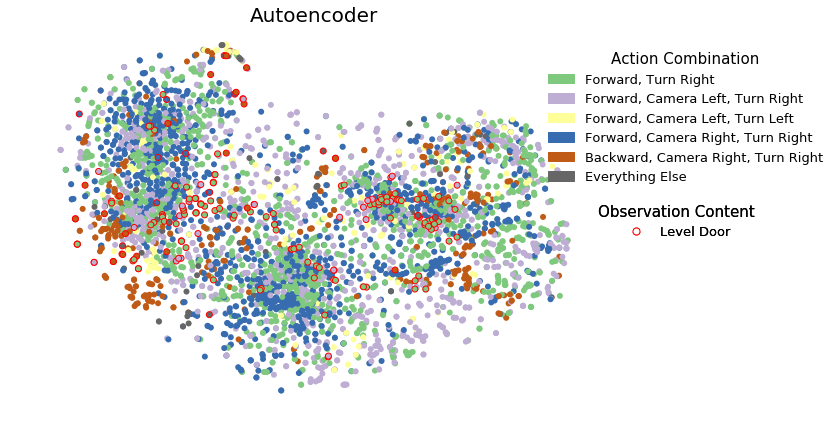

In [31]:
fig = plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Autoencoder', fontsize=20)
im1 = plt.scatter(tsneAE[newOrder,0],tsneAE[newOrder,1],c=all_a_comb[newOrder],cmap='Accent',edgecolors=edgeCs[newOrder],linewidths =edgeWs[newOrder])
values = np.linspace(0,5,6)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=act_lab[i] ) for i in range(len(values)) ]
l1 = plt.legend(handles=patches, bbox_to_anchor=(0.91, 0.95), loc=2, borderaxespad=0. , title='Action Combination',title_fontsize=15,fontsize=13,frameon=False)

line1 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="red")
line2 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="white")
l2 = plt.legend((line1,line2),('Level Door',''), bbox_to_anchor=(1, 0.55),numpoints=1, loc=2,fontsize=13,title="Observation Content",title_fontsize=15,frameon=False, borderaxespad=0.)

fig.add_artist(l1)
fig.add_artist(l2)

plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_actions_AE.eps', bbox_inches='tight',dpi=300)

#### T-SNE Colored by Action - Classifier

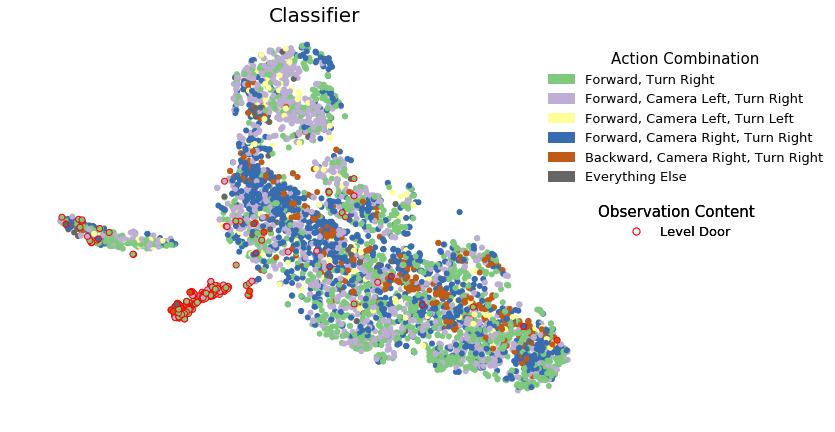

In [32]:
fig = plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Classifier', fontsize=20)
im1 = plt.scatter(tsneC[newOrder,0],tsneC[newOrder,1],c=all_a_comb[newOrder],cmap='Accent',edgecolors=edgeCs[newOrder],linewidths =edgeWs[newOrder])
values = np.linspace(0,5,6)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=act_lab[i] ) for i in range(len(values)) ]
l1 = plt.legend(handles=patches, bbox_to_anchor=(0.91, 0.95), loc=2, borderaxespad=0. , title='Action Combination',title_fontsize=15,fontsize=13,frameon=False)

line1 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="red")
line2 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="white")
l2 = plt.legend((line1,line2),('Level Door',''), bbox_to_anchor=(1, 0.55),numpoints=1, loc=2,fontsize=13,title="Observation Content",title_fontsize=15,frameon=False, borderaxespad=0.)

fig.add_artist(l1)
fig.add_artist(l2)

plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_actions_C.eps', bbox_inches='tight',dpi=300)

### Variance in Action Clusters

In [33]:
num_act = np.unique(all_a_comb).shape[0]
_,_,bA,wA = getClusterVariance(all_a_comb,encA,num_act)
_,_,bAE,wAE = getClusterVariance(all_a_comb,encAE,num_act)
_,_,bC,wC = getClusterVariance(all_a_comb,encC,num_act)

In [34]:
print("Embodied Agent: Between class variance: "+str(np.round(bA,4)))
print("Embodied Agent: within class variance:"+str(np.round(wA,4)))
print("Relative class variance: "+str(np.round(wA/bA,4)))
print("Average class variance: "+str(np.round(np.mean(wA/bA),4)))
print("Average class variance, class 0-4: "+str(np.round(np.mean(wA[:4]/bA),4))+" Last 2: "+str(np.round(np.mean(wA[4:]/bA),4)))
print("Mean absolute distance from 1: "+str(np.round(np.mean(np.abs(1-wA/bA)),3)))

print("\nAutoencoder: Between class variance: "+str(np.round(bAE,4)))
print("Autoencoder: within class variance:"+str(np.round(wAE,4)))
print("Relative class variance: "+str(np.round(wAE/bAE,4)))
print("Average class variance: "+str(np.round(np.mean(wAE/bAE),4)))
print("Average class variance, class 0-4: "+str(np.round(np.mean(wAE[:4]/bAE),4))+" Last 2: "+str(np.round(np.mean(wAE[4:]/bAE),4)))
print("Mean absolute distance from 1: "+str(np.round(np.mean(np.abs(1-wAE/bAE)),3)))

print("\nClassifier: Between class variance: "+str(np.round(bC,4)))
print("Classifier: within class variance:"+str(np.round(wC,4)))
print("Relative class variance: "+str(np.round(wC/bC,4)))
print("Average class variance: "+str(np.round(np.mean(wC/bC),4)))
print("Average class variance, class 0-4: "+str(np.round(np.mean(wC[:4]/bC),4))+" Last 2: "+str(np.round(np.mean(wC[4:]/bC),4)))
print("Mean absolute distance from 1: "+str(np.round(np.mean(np.abs(1-wC/bC)),3)))

Embodied Agent: Between class variance: 23.0799
Embodied Agent: within class variance:[16.6139 13.4569 14.7458  8.9584 32.4644 44.1316]
Relative class variance: [0.7198 0.5831 0.6389 0.3881 1.4066 1.9121]
Average class variance: 0.9414
Average class variance, class 0-4: 0.5825 Last 2: 1.6594
Mean absolute distance from 1: 0.498

Autoencoder: Between class variance: 0.0597
Autoencoder: within class variance:[0.0541 0.064  0.0771 0.0542 0.0613 0.0912]
Relative class variance: [0.9059 1.0725 1.291  0.9089 1.0277 1.5288]
Average class variance: 1.1225
Average class variance, class 0-4: 1.0446 Last 2: 1.2783
Mean absolute distance from 1: 0.184

Classifier: Between class variance: 456651460.0
Classifier: within class variance:[6.12626624e+08 2.70363136e+08 1.49529584e+08 4.63426368e+08
 2.66905120e+08 1.49597158e+09]
Relative class variance: [1.3416 0.5921 0.3274 1.0148 0.5845 3.276 ]
Average class variance: 1.1894
Average class variance, class 0-4: 0.819 Last 2: 1.9302
Mean absolute distan

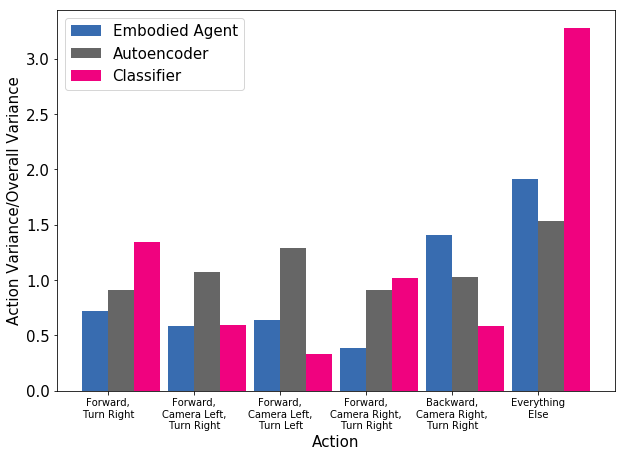

In [35]:
action_C = ['Forward,\nTurn Right','Forward,\nCamera Left,\nTurn Right','Forward,\nCamera Left,\nTurn Left',
           'Forward,\nCamera Right,\nTurn Right','Backward,\nCamera Right,\nTurn Right','Everything\nElse']

plt.figure(figsize=(10,7))
plt.bar(np.linspace(-0.15,4.85,6),wA/bA,width=0.3,color=sns.color_palette("Accent", n_colors=8)[4])
plt.bar(np.linspace(0.15,5.15,6),wAE/bAE,width=0.3,color=sns.color_palette("Accent", n_colors=8)[7])
plt.bar(np.linspace(0.45,5.45,6),wC/bC,width=0.3,color=sns.color_palette("Accent", n_colors=8)[5])

#plt.title('Variance within Encodings Corresponding to one Action',fontsize=20)
plt.xlabel('Action',fontsize=15)
plt.ylabel('Action Variance/Overall Variance',fontsize=15)
plt.legend(['Embodied Agent','Autoencoder','Classifier'],fontsize=15)

plt.yticks(fontsize=15)
plt.xticks(np.linspace(0,5,6),action_C,fontsize=10)
plt.savefig(figure_path+'HighD_Action_Variances.eps', bbox_inches='tight',dpi=300)
#plt.show()

### Distances Within Action Clusters

In [36]:
num_act = np.unique(all_a_comb).shape[0]

allDA = getDistances(encA)
allD_varA = np.var(allDA)
allDA = np.mean(allDA)

acc_dA = np.zeros(num_act)
acc_d_varA = np.zeros(num_act)
for acc in range(num_act):
    acc_dA[acc] = np.mean(getDistances(encA[all_a_comb==acc]))
    acc_d_varA[acc] = np.var(getDistances(encA[all_a_comb==acc]))

allDAE = getDistances(encAE)
allD_varAE = np.var(allDAE)
allDAE = np.mean(allDAE)

acc_dAE = np.zeros(num_act)
acc_d_varAE = np.zeros(num_act)
for acc in range(num_act):
    acc_dAE[acc] = np.mean(getDistances(encAE[all_a_comb==acc]))
    acc_d_varAE[acc] = np.var(getDistances(encAE[all_a_comb==acc]))

allDC = getDistances(encC)
allD_varC = np.var(allDC)
allDC = np.mean(allDC)

acc_dC = np.zeros(num_act)
acc_d_varC = np.zeros(num_act)
for acc in range(num_act):
    acc_dC[acc] = np.mean(getDistances(encC[all_a_comb==acc]))
    acc_d_varC[acc] = np.var(getDistances(encC[all_a_comb==acc]))


In [37]:
print("Embodied Agent:")
print("Average distance within action clusters/overall distances: "+str(np.round(np.mean(acc_dA)/allDA,3)))
print("For first four actions: "+str(np.round(np.mean(acc_dA[:4])/allDA,3)))
print("Last two actions: "+str(np.round(np.mean(acc_dA[4:])/allDA,3)))
print("Mean absolute distance from 1: "+str(np.round(np.mean(np.abs(1-acc_dA/allDA)),3)))

print("Autoencoder:")
print("Average distance within action clusters/overall distances: "+str(np.round(np.mean(acc_dAE)/allDAE,3)))
print("For first four actions: "+str(np.round(np.mean(acc_dAE[:4])/allDAE,3)))
print("Last two actions: "+str(np.round(np.mean(acc_dAE[4:])/allDAE,3)))
print("Mean absolute distance from 1: "+str(np.round(np.mean(np.abs(1-acc_dAE/allDAE)),3)))

print("Classifier:")
print("Average distance within action clusters/overall distances: "+str(np.round(np.mean(acc_dC)/allDC,3)))
print("For first four actions: "+str(np.round(np.mean(acc_dC[:4])/allDC,3)))
print("Last two actions: "+str(np.round(np.mean(acc_dC[4:])/allDC,3)))
print("Mean absolute distance from 1: "+str(np.round(np.mean(np.abs(1-acc_dC/allDC)),3)))

Embodied Agent:
Average distance within action clusters/overall distances: 0.96
For first four actions: 0.78
Last two actions: 1.319
Mean absolute distance from 1: 0.253
Autoencoder:
Average distance within action clusters/overall distances: 1.055
For first four actions: 1.02
Last two actions: 1.124
Mean absolute distance from 1: 0.087
Classifier:
Average distance within action clusters/overall distances: 1.079
For first four actions: 0.943
Last two actions: 1.351
Mean absolute distance from 1: 0.328


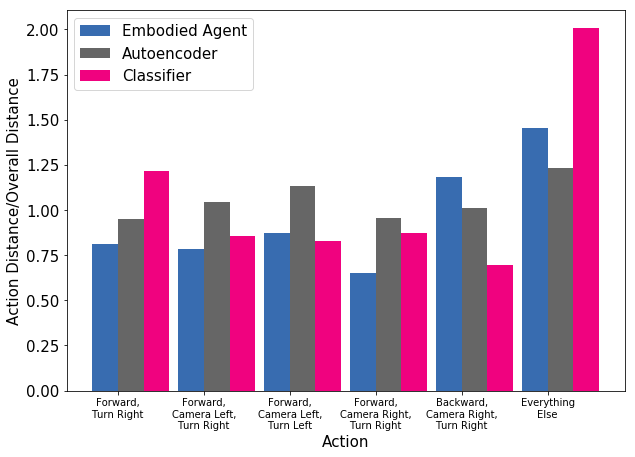

In [38]:
action_C = ['Forward,\nTurn Right','Forward,\nCamera Left,\nTurn Right','Forward,\nCamera Left,\nTurn Left',
           'Forward,\nCamera Right,\nTurn Right','Backward,\nCamera Right,\nTurn Right','Everything\nElse']

plt.figure(figsize=(10,7))

plt.bar(np.linspace(-0.15,4.85,6),acc_dA/allDA,width=0.3,color=sns.color_palette("Accent", n_colors=8)[4])
plt.bar(np.linspace(0.15,5.15,6),acc_dAE/allDAE,width=0.3,color=sns.color_palette("Accent", n_colors=8)[7])
plt.bar(np.linspace(0.45,5.45,6),acc_dC/allDC,width=0.3,color=sns.color_palette("Accent", n_colors=8)[5])

#plt.title('Distance Within Encodings Corresponding to one Action',fontsize=20)
plt.xlabel('Action',fontsize=15)
plt.ylabel('Action Distance/Overall Distance',fontsize=15)
plt.legend(['Embodied Agent','Autoencoder','Classifier'],fontsize=15)

plt.yticks(fontsize=15)
plt.xticks(np.linspace(0,5,6),action_C,fontsize=10)
plt.savefig(figure_path+'HighD_Action_Distances.eps', bbox_inches='tight',dpi=300)
#plt.show()

### Distances Between Pairs of Cluster Combinations & Cluster Distance Index (CDI)

In [39]:
acrossA = []
for c1,c2 in combinations(np.linspace(0,5,6), 2):
    acd = np.mean(getAcrossD(encA[all_a_comb==c1],encA[all_a_comb==c2]))
    print(str(c1)+' - '+str(c2)+' = '+str(acd))
    acrossA.append(acd)

0.0 - 1.0 = 88.37677544331756
0.0 - 2.0 = 115.1886156053709
0.0 - 3.0 = 87.73313555534834
0.0 - 4.0 = 148.05661635322912
0.0 - 5.0 = 140.48637336695555
1.0 - 2.0 = 106.64202965826726
1.0 - 3.0 = 92.03496187501335
1.0 - 4.0 = 145.08730091605847
1.0 - 5.0 = 134.82729300853308
2.0 - 3.0 = 101.33718664092378
2.0 - 4.0 = 142.87522853761314
2.0 - 5.0 = 133.48234486888956
3.0 - 4.0 = 126.34854945876442
3.0 - 5.0 = 126.58349841237427
4.0 - 5.0 = 142.19468446428996


In [40]:
acrossAE = []
for c1,c2 in combinations(np.linspace(0,5,6), 2):
    acd = np.mean(getAcrossD(encAE[all_a_comb==c1],encAE[all_a_comb==c2]))
    print(str(c1)+' - '+str(c2)+' = '+str(acd))
    acrossAE.append(acd)

0.0 - 1.0 = 5.427109385003088
0.0 - 2.0 = 5.746082633706965
0.0 - 3.0 = 5.177355584535358
0.0 - 4.0 = 5.4092047283354345
0.0 - 5.0 = 6.045880612474591
1.0 - 2.0 = 5.941527761959425
1.0 - 3.0 = 5.467815018828714
1.0 - 4.0 = 5.709554747829967
1.0 - 5.0 = 6.273236172937597
2.0 - 3.0 = 5.770352487451393
2.0 - 4.0 = 5.979175763062564
2.0 - 5.0 = 6.489590806182888
3.0 - 4.0 = 5.409642759211643
3.0 - 5.0 = 6.02118263908759
4.0 - 5.0 = 6.164611357570173


In [41]:
acrossC = []
for c1,c2 in combinations(np.linspace(0,5,6), 2):
    acd = np.mean(getAcrossD(encC[all_a_comb==c1],encC[all_a_comb==c2]))
    print(str(c1)+' - '+str(c2)+' = '+str(acd))
    acrossC.append(acd)

0.0 - 1.0 = 266969.0116676625
0.0 - 2.0 = 264255.84146309266
0.0 - 3.0 = 268973.47553684644
0.0 - 4.0 = 249870.58397902548
0.0 - 5.0 = 417804.10501577635
1.0 - 2.0 = 213521.25747506344
1.0 - 3.0 = 225010.16318396796
1.0 - 4.0 = 208621.9915568427
1.0 - 5.0 = 371842.9975654743
2.0 - 3.0 = 223708.0123082721
2.0 - 4.0 = 207567.19819167213
2.0 - 5.0 = 367911.5271319354
3.0 - 4.0 = 201809.22576756825
3.0 - 5.0 = 381982.8968369588
4.0 - 5.0 = 368872.0355134405


In [42]:
withinA = np.mean(acc_dA)
withinAE = np.mean(acc_dAE)
withinC = np.mean(acc_dC)
print('Average Distance within Clusters - Embodied Agent: '+str(withinA))
print('Average Distance within Clusters - Autoencoder: '+str(withinAE))
print('Average Distance within Clusters - Classifier: '+str(withinC))

Average Distance within Clusters - Embodied Agent: 91.3866435667792
Average Distance within Clusters - Autoencoder: 5.703788906911626
Average Distance within Clusters - Classifier: 273321.2777135588


In [43]:
acrossAllA = np.mean(acrossA)
acrossAllAE = np.mean(acrossAE)
acrossAllC = np.mean(acrossC)
print('Average Distance across all Cluster Combinations - Embodied Agent: '+str(acrossAllA))
print('Average Distance across all Cluster Combinations - Autoencoder: '+str(acrossAllAE))
print('Average Distance across all Cluster Combinations - Classifier: '+str(acrossAllC))

Average Distance across all Cluster Combinations - Embodied Agent: 122.0836396109966
Average Distance across all Cluster Combinations - Autoencoder: 5.80215483054516
Average Distance across all Cluster Combinations - Classifier: 282581.3548795733


In [44]:
CDI_A = (acrossAllA-withinA)/allDA
CDI_AE = (acrossAllAE-withinAE)/allDAE
CDI_C = (acrossAllC-withinC)/allDC
print('Cluster Distance Index (CDI) - Embodied Agent: '+str(CDI_A))
print('Cluster Distance Index (CDI) - Autoencoder: '+str(CDI_AE))
print('Cluster Distance Index (CDI) - Classifier: '+str(CDI_C))

Cluster Distance Index (CDI) - Embodied Agent: 0.32237646037925616
Cluster Distance Index (CDI) - Autoencoder: 0.018188671517248085
Cluster Distance Index (CDI) - Classifier: 0.03654843917528356


### Cluster Correlations & Cluster Correlation Index (CCI)

In [45]:
allD_cA = getCorDistances(encA)
allD_cA = np.mean(allD_cA)
print('Embodied Agent - Overall Correlation Distances: '+str(allD_cA))

acc_d_cA = np.zeros(num_act)
for acc in range(num_act):
    acc_d_cA[acc] = np.mean(getCorDistances(encA[all_a_comb==acc]))
print('Embodied Agent - Cluster Distances: '+str(acc_d_cA))

allD_cAE = getCorDistances(encAE)
allD_cAE = np.mean(allD_cAE)
print('Autoencoder - Overall Correlation Distances: '+str(allD_cAE))

acc_d_cAE = np.zeros(num_act)
for acc in range(num_act):
    acc_d_cAE[acc] = np.mean(getCorDistances(encAE[all_a_comb==acc]))
print('Autoencoder - Cluster Distances: '+str(acc_d_cAE))

allD_cC = getCorDistances(encC)
allD_cC = np.mean(allD_cC)
print('Classifier - Overall Correlation Distances: '+str(allD_cC))

acc_d_cC = np.zeros(num_act)
for acc in range(num_act):
    acc_d_cC[acc] = np.mean(getCorDistances(encC[all_a_comb==acc]))
print('Classifier - Cluster Distances: '+str(acc_d_cC))

within_cA = np.mean(acc_d_cA)
within_cAE = np.mean(acc_d_cAE)
within_cC = np.mean(acc_d_cC)
within4_cA = np.mean(acc_d_cA[:4])

across_corA = []
for c1,c2 in combinations(np.linspace(0,5,6), 2):
    acd = np.mean(getAcrossCorD(encA[all_a_comb==c1],encA[all_a_comb==c2]))
    print(str(c1)+' - '+str(c2)+' = '+str(acd))
    across_corA.append(acd)
acrossAll_cA = np.mean(across_corA)
print('Embodied Agent - Across Correlation Distance (Avg): '+str(acrossAll_cA))
    
across_corAE = []
for c1,c2 in combinations(np.linspace(0,5,6), 2):
    acd = np.mean(getAcrossCorD(encAE[all_a_comb==c1],encAE[all_a_comb==c2]))
    print(str(c1)+' - '+str(c2)+' = '+str(acd))
    across_corAE.append(acd)
acrossAll_cAE = np.mean(across_corAE)
print('Autoencoder - Across Correlation Distance (Avg): '+str(acrossAll_cAE))

across_corC = []
for c1,c2 in combinations(np.linspace(0,5,6), 2):
    acd = np.mean(getAcrossCorD(encC[all_a_comb==c1],encC[all_a_comb==c2]))
    print(str(c1)+' - '+str(c2)+' = '+str(acd))
    across_corC.append(acd)
acrossAll_cC = np.mean(across_corC)
print('Classifier - Across Correlation Distance (Avg): '+str(acrossAll_cC))
    
print('CCI (corr-dist) - Embodied Agent: '+str((acrossAll_cA-within_cA)/allD_cA))
print('CCI (corr-dist) - Autoencoder: '+str((acrossAll_cAE-within_cAE)/allD_cAE))
print('CCI (corr-dist) - Classifier: '+str((acrossAll_cC-within_cC)/allD_cC))

Embodied Agent - Overall Correlation Distances: 0.6765368116260169
Embodied Agent - Cluster Distances: [0.3361146  0.44061131 0.44806158 0.48745281 0.31786979 0.64782569]
Autoencoder - Overall Correlation Distances: 0.3932678472387932
Autoencoder - Cluster Distances: [0.37627306 0.40236284 0.43485428 0.36590437 0.42020975 0.48025333]
Classifier - Overall Correlation Distances: 0.14474215266523988
Classifier - Cluster Distances: [0.17682128 0.13088617 0.13772942 0.11688351 0.09062559 0.13054221]
0.0 - 1.0 = 0.5637933640937131
0.0 - 2.0 = 0.9369249589559191
0.0 - 3.0 = 0.6954508676521799
0.0 - 4.0 = 0.9617965819216713
0.0 - 5.0 = 0.9486487422175248
1.0 - 2.0 = 0.8627901434776417
1.0 - 3.0 = 0.8864256006380832
1.0 - 4.0 = 0.9838772416008948
1.0 - 5.0 = 0.923997131146651
2.0 - 3.0 = 0.9314718380287985
2.0 - 4.0 = 0.8697216463614568
2.0 - 5.0 = 0.822368595557956
3.0 - 4.0 = 0.7835675041951382
3.0 - 5.0 = 0.91083408761266
4.0 - 5.0 = 0.633377788148358
Embodied Agent - Across Correlation Dist

### Distances Between 'Level Door' and 'No Level Door' Frames

In [46]:
label_test = np.array(hand_l['Label'])
doorFrames = label_test
doorFrames[doorFrames!=6] = 0
doorFrames[doorFrames==6] = 1

In [49]:
doorDA = getDistances(encA[doorFrames==1])
noDoorDA = getDistances(encA[doorFrames==0])

doorDAE = getDistances(encAE[doorFrames==1])
noDoorDAE = getDistances(encAE[doorFrames==0])

doorDC = getDistances(encC[doorFrames==1])
noDoorDC = getDistances(encC[doorFrames==0])

In [50]:
print("Embodied Agent")
print("Door frames: Average Distance = "+str(np.round(np.mean(doorDA)/allDA,3))+" Var = "+str(np.round(np.var(doorDA),3)))
print("No Door frames: Average Distance = "+str(np.round(np.mean(noDoorDA)/allDA,3))+" Var = "+str(np.round(np.var(noDoorDA),3)))

print("Autoencoder")
print("Door frames: Average Distance = "+str(np.round(np.mean(doorDAE)/allDAE,3))+" Var = "+str(np.round(np.var(doorDAE),3)))
print("No Door frames: Average Distance = "+str(np.round(np.mean(noDoorDAE)/allDAE,3))+" Var = "+str(np.round(np.var(noDoorDAE),3)))

print("Classifier")
print("Door frames: Average Distance = "+str(np.round(np.mean(doorDC)/allDC,3))+" Var = "+str(np.round(np.var(doorDC),3)))
print("No Door frames: Average Distance = "+str(np.round(np.mean(noDoorDC)/allDC,3))+" Var = "+str(np.round(np.var(noDoorDC),3)))

Embodied Agent
Door frames: Average Distance = 2.025 Var = 9135.037
No Door frames: Average Distance = 0.923 Var = 1835.446
Autoencoder
Door frames: Average Distance = 0.93 Var = 1.311
No Door frames: Average Distance = 1.002 Var = 1.312
Classifier
Door frames: Average Distance = 1.915 Var = 290273605759.137
No Door frames: Average Distance = 0.911 Var = 155685322139.77
